Initialize the environment

In [ ]:
import os
import sys

os.execv(sys.executable, [sys.executable] + sys.argv)

: 

In [1]:
import torch
import argparse

print(torch.__version__)
print(torch.cuda.is_available())

2.8.0.dev20250524+cu128
True


In [2]:
import torch

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [ ]:
from TamGen_RL import TamGenRL
from utils import prepare_pdb_data, prepare_pdb_data_center, filter_generated_cmpd
import torch

torch.cuda.empty_cache()
torch.cuda.ipc_collect()

# === Setup TamGenRL ===
pdb_id = "3ny8"
print(f"📄 Preparing PDB: {pdb_id}")
prepare_pdb_data(pdb_id)

demo = TamGenRL(
    data="TamGen_Demo_Data",
    ckpt="checkpoints/crossdocked_model/checkpoint_best.pt",
    use_conditional=True
)
demo.reload_data(subset="gen_" + pdb_id.lower())

# === Run Closed-Loop Optimization ===
final_smiles = demo.sample(
    m_sample=50000,         # Number of molecules per iteration
    num_iter=5,           # Number of closed-loop optimization steps
    latent_dim=256,       # Latent space dimensionality (set to your model's config)
    alpha=0.5,            # Centroid shift parameter
    top_k=50,             # How many top molecules to use for shifting
    lambda_sas=0.3,       # Reward hyperparameters
    lambda_logp=0.1,
    lambda_mw=0.1,
    maxseed=20,           # Number of random seeds (first iteration)
    use_cuda=True
)

# === Save or Analyze Results ===
print(f"\nFinal set of SMILES ({len(final_smiles)} molecules):")
for smi in final_smiles:
    print(smi)

📄 Preparing PDB: 3ny8
3ny8 is downloaded
Namespace(no_progress_bar=False, log_interval=1000, log_format=None, tensorboard_logdir='', tbmf_wrapper=False, seed=1, cpu=False, fp16=False, memory_efficient_fp16=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer='nag', lr_scheduler='fixed', task='translation_coord', num_workers=1, skip_invalid_size_inputs_valid_test=False, max_tokens=1024, max_sentences=None, required_batch_size_multiple=8, dataset_impl=None, gen_subset='gen_8fln', num_shards=1, shard_id=0, path='checkpoints/crossdocked_model/checkpoint_best.pt', remove_bpe=None, quiet=False, model_overrides='{}', results_path=None, beam=20, nbest=20, max_len_a=0, max_len_b=200, min_len=1, match_source_len=False, no_early_stop=False, unnormalized=False, no_beamable_mm=False, lenpen=1, unkpen=0, replace_unk=None, sacrebleu=False, score_refe

  0%|          | 0/20 [00:00<?, ?it/s]/workspace/workspace/TamGen/fairseq/sequence_generator.py:456: UserWarning: An output with one or more elements was resized since it had shape [5, 20], which does not match the required output shape [4, 20]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /pytorch/aten/src/ATen/native/Resize.cpp:31.)
  torch.topk(
/workspace/workspace/TamGen/fairseq/sequence_generator.py:466: UserWarning: An output with one or more elements was resized since it had shape [5, 20], which does not match the required output shape [4, 20]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered inte

Total valid SMILES and latents after all seeds: 95
Preview of valid SMILES: ['Cc1ccc(OC[C@@H](O)[C@H](C)NC(C)C)c2c1CCC2', 'CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@]12C', 'CCCCCCCC/C=C\\CCCCCCCC(=O)OC[C@H](O)CO', 'CCCCCCCC/C=C\\CCCCCCCC(=O)O', 'OCCOCCOCCO', 'Cc1ccc(OC[C@@H](O)[C@H](C)NC(C)C)c2c1CCC2', 'CC(C)CCC[C@@H](C)[C@H]1CC[C@H]2[C@@H]3CC=C4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@]12C', 'CCCCCCCC/C=C\\CCCCCCCC(=O)OC[C@H](O)CO', 'CCCCCCCC/C=C\\CCCCCCCC(=O)O', 'OCCOCCOCCO']
Preview of latent vector shapes: [(256,), (256,), (256,), (256,), (256,), (256,), (256,), (256,), (256,), (256,)]
Unique SMILES this iteration: 5 / 95
📊 Optimizing latent space...
[DEBUG] Model created on device: cpu
[DEBUG] z_tensor device: cpu, r_tensor device: cpu
[DEBUG] Cleared z_list and r_list after training.
Model parameters devices: [device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]
Stored tensors devices: []


ValueError: need at least one array to stack

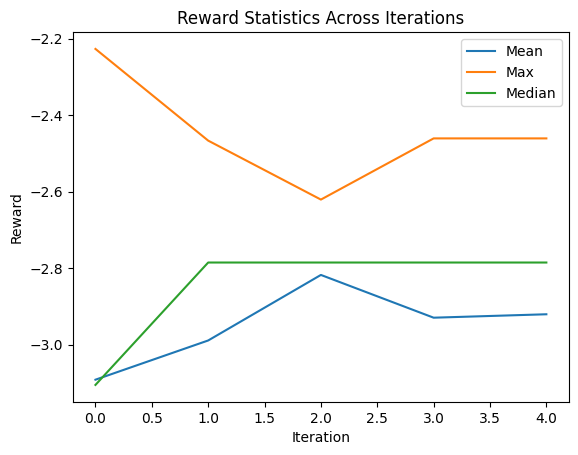

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt

reward_files = sorted(glob.glob('latent_logs/rewards_iter_*.tsv'))
means, maxs, medians = [], [], []

for f in reward_files:
    rewards = []
    with open(f) as fin:
        for line in fin:
            parts = line.strip().split('\t')
            if len(parts) == 2:
                rewards.append(float(parts[1]))
    if rewards:
        rewards = np.array(rewards)
        means.append(rewards.mean())
        maxs.append(rewards.max())
        medians.append(np.median(rewards))

plt.plot(means, label='Mean')
plt.plot(maxs, label='Max')
plt.plot(medians, label='Median')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('Reward Statistics Across Iterations')
plt.legend()
plt.show()

🔬 REWARD CONVERGENCE ANALYSIS
📊 Found 50 iteration files
   Iter 1: 20 molecules, 5 unique, reward range [-3.627, -2.227]
   Iter 2: 20 molecules, 8 unique, reward range [-3.682, -2.461]
   Iter 3: 20 molecules, 8 unique, reward range [-3.682, -2.542]
   Iter 4: 20 molecules, 6 unique, reward range [-3.668, -2.461]
   Iter 5: 20 molecules, 5 unique, reward range [-3.668, -2.461]
   Iter 6: 20 molecules, 6 unique, reward range [-3.600, -2.461]
   Iter 7: 20 molecules, 7 unique, reward range [-3.600, -2.461]
   Iter 8: 20 molecules, 7 unique, reward range [-3.600, -2.461]
   Iter 9: 20 molecules, 6 unique, reward range [-3.600, -2.461]
   Iter 10: 20 molecules, 6 unique, reward range [-3.600, -2.461]
   Iter 11: 20 molecules, 6 unique, reward range [-3.600, -2.461]
   Iter 12: 20 molecules, 6 unique, reward range [-3.600, -2.467]
   Iter 13: 20 molecules, 6 unique, reward range [-3.600, -2.461]
   Iter 14: 20 molecules, 6 unique, reward range [-3.600, -2.461]
   Iter 15: 20 molecules, 5 

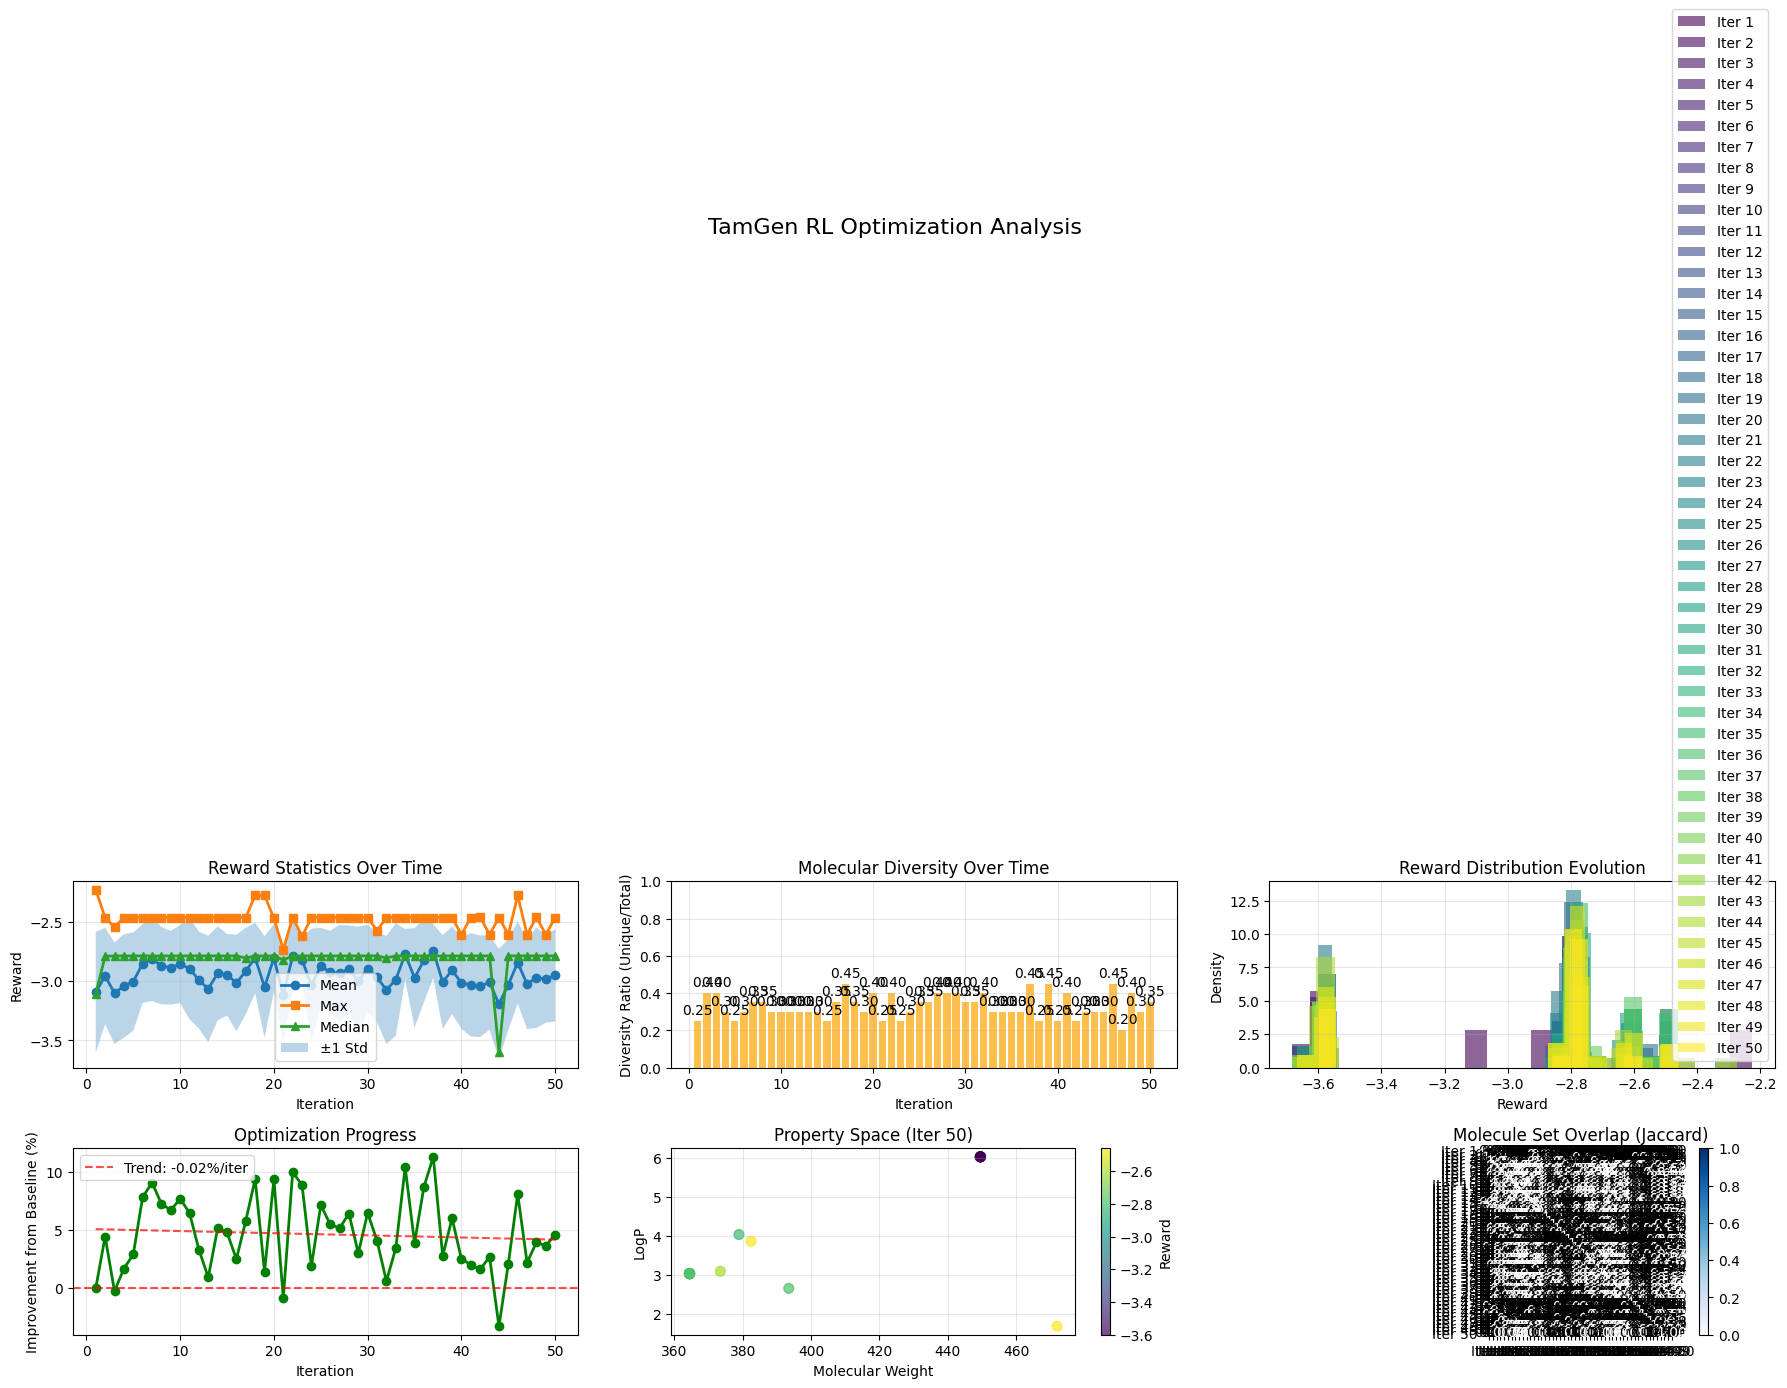


📈 DETAILED ANALYSIS
📈 TRENDING: Mean rewards still changing (std = 0.012)
📊 OVERALL IMPROVEMENT: +4.6% from baseline
🏆 BEST MOLECULE: Cc1ccc(OC[C@@H](O)[C@H](C)NC(C)C)c2c1CCC2
   Reward: -2.227 (Iteration 1)
➡️ DIVERSITY STABLE: 0.000/iteration

💡 RECOMMENDATIONS
🔄 CONSIDER STOPPING: Minimal recent improvement
   - Try different hyperparameters
   - Or accept current results


In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import seaborn as sns

def analyze_reward_convergence():
    """
    Comprehensive analysis of reward function convergence and molecular properties
    """
    
    print("🔬 REWARD CONVERGENCE ANALYSIS")
    print("=" * 60)
    
    # Load reward files
    reward_files = sorted(glob.glob('latent_logs/rewards_iter_*.tsv'))
    if not reward_files:
        print("❌ No reward files found in latent_logs/")
        return
    
    print(f"📊 Found {len(reward_files)} iteration files")
    
    # Parse data
    iteration_data = {}
    all_molecules = set()
    
    for i, f in enumerate(reward_files):
        rewards = []
        molecules = []
        with open(f) as fin:
            for line in fin:
                parts = line.strip().split('\t')
                if len(parts) == 2:
                    mol_smiles = parts[0]
                    reward = float(parts[1])
                    rewards.append(reward)
                    molecules.append(mol_smiles)
                    all_molecules.add(mol_smiles)
        
        iteration_data[i+1] = {
            'rewards': np.array(rewards),
            'molecules': molecules,
            'mean': np.mean(rewards),
            'max': np.max(rewards),
            'median': np.median(rewards),
            'std': np.std(rewards),
            'unique_count': len(set(molecules))
        }
        
        print(f"   Iter {i+1}: {len(rewards)} molecules, {len(set(molecules))} unique, "
              f"reward range [{np.min(rewards):.3f}, {np.max(rewards):.3f}]")
    
    # Create comprehensive plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('TamGen RL Optimization Analysis', fontsize=16)
    
    iterations = list(iteration_data.keys())
    
    # 1. Reward Statistics Over Time
    ax1 = axes[0, 0]
    means = [iteration_data[i]['mean'] for i in iterations]
    maxs = [iteration_data[i]['max'] for i in iterations]
    medians = [iteration_data[i]['median'] for i in iterations]
    stds = [iteration_data[i]['std'] for i in iterations]
    
    ax1.plot(iterations, means, 'o-', label='Mean', linewidth=2)
    ax1.plot(iterations, maxs, 's-', label='Max', linewidth=2)
    ax1.plot(iterations, medians, '^-', label='Median', linewidth=2)
    ax1.fill_between(iterations, 
                     [m - s for m, s in zip(means, stds)],
                     [m + s for m, s in zip(means, stds)],
                     alpha=0.3, label='±1 Std')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Reward')
    ax1.set_title('Reward Statistics Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Diversity Analysis
    ax2 = axes[0, 1]
    total_counts = [len(iteration_data[i]['molecules']) for i in iterations]
    unique_counts = [iteration_data[i]['unique_count'] for i in iterations]
    diversity_ratios = [u/t for u, t in zip(unique_counts, total_counts)]
    
    ax2.bar(iterations, diversity_ratios, alpha=0.7, color='orange')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Diversity Ratio (Unique/Total)')
    ax2.set_title('Molecular Diversity Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # Add text annotations
    for i, ratio in zip(iterations, diversity_ratios):
        ax2.text(i, ratio + 0.02, f'{ratio:.2f}', ha='center', va='bottom')
    
    # 3. Reward Distribution Evolution
    ax3 = axes[0, 2]
    colors = plt.cm.viridis(np.linspace(0, 1, len(iterations)))
    for i, color in zip(iterations, colors):
        rewards = iteration_data[i]['rewards']
        ax3.hist(rewards, bins=20, alpha=0.6, label=f'Iter {i}', 
                color=color, density=True)
    ax3.set_xlabel('Reward')
    ax3.set_ylabel('Density')
    ax3.set_title('Reward Distribution Evolution')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Convergence Analysis
    ax4 = axes[1, 0]
    # Calculate running improvement
    improvements = []
    base_mean = means[0]
    for mean in means:
        improvements.append((mean - base_mean) / abs(base_mean) * 100)
    
    ax4.plot(iterations, improvements, 'o-', linewidth=2, color='green')
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Improvement from Baseline (%)')
    ax4.set_title('Optimization Progress')
    ax4.grid(True, alpha=0.3)
    
    # Add trend line
    if len(iterations) > 2:
        z = np.polyfit(iterations, improvements, 1)
        p = np.poly1d(z)
        ax4.plot(iterations, p(iterations), '--', alpha=0.7, color='red',
                label=f'Trend: {z[0]:.2f}%/iter')
        ax4.legend()
    
    # 5. Molecular Property Analysis (if we can parse SMILES)
    ax5 = axes[1, 1]
    try:
        # Analyze molecular properties for last iteration
        last_iter = max(iterations)
        last_molecules = iteration_data[last_iter]['molecules']
        last_rewards = iteration_data[last_iter]['rewards']
        
        # Calculate molecular properties
        mw_values = []
        logp_values = []
        valid_rewards = []
        
        for mol_smiles, reward in zip(last_molecules, last_rewards):
            mol = Chem.MolFromSmiles(mol_smiles)
            if mol is not None:
                mw = Descriptors.MolWt(mol)
                logp = Descriptors.MolLogP(mol)
                mw_values.append(mw)
                logp_values.append(logp)
                valid_rewards.append(reward)
        
        if mw_values:
            scatter = ax5.scatter(mw_values, logp_values, c=valid_rewards, 
                                cmap='viridis', alpha=0.7, s=50)
            ax5.set_xlabel('Molecular Weight')
            ax5.set_ylabel('LogP')
            ax5.set_title(f'Property Space (Iter {last_iter})')
            plt.colorbar(scatter, ax=ax5, label='Reward')
            ax5.grid(True, alpha=0.3)
        else:
            ax5.text(0.5, 0.5, 'No valid molecules\nfor property analysis', 
                    ha='center', va='center', transform=ax5.transAxes)
            ax5.set_title('Property Analysis Failed')
    
    except Exception as e:
        ax5.text(0.5, 0.5, f'Property analysis failed:\n{str(e)}', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Property Analysis Error')
    
    # 6. Molecule Overlap Analysis
    ax6 = axes[1, 2]
    if len(iterations) > 1:
        overlap_matrix = np.zeros((len(iterations), len(iterations)))
        for i, iter1 in enumerate(iterations):
            for j, iter2 in enumerate(iterations):
                set1 = set(iteration_data[iter1]['molecules'])
                set2 = set(iteration_data[iter2]['molecules'])
                overlap = len(set1.intersection(set2)) / len(set1.union(set2))
                overlap_matrix[i, j] = overlap
        
        im = ax6.imshow(overlap_matrix, cmap='Blues', vmin=0, vmax=1)
        ax6.set_xticks(range(len(iterations)))
        ax6.set_yticks(range(len(iterations)))
        ax6.set_xticklabels([f'Iter {i}' for i in iterations])
        ax6.set_yticklabels([f'Iter {i}' for i in iterations])
        ax6.set_title('Molecule Set Overlap (Jaccard)')
        plt.colorbar(im, ax=ax6)
        
        # Add text annotations
        for i in range(len(iterations)):
            for j in range(len(iterations)):
                ax6.text(j, i, f'{overlap_matrix[i, j]:.2f}',
                        ha='center', va='center', 
                        color='white' if overlap_matrix[i, j] > 0.5 else 'black')
    else:
        ax6.text(0.5, 0.5, 'Need multiple iterations\nfor overlap analysis', 
                ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Molecule Overlap Analysis')
    
    plt.tight_layout()
    plt.savefig('latent_logs/reward_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed analysis
    print("\n📈 DETAILED ANALYSIS")
    print("=" * 60)
    
    # Convergence assessment
    if len(iterations) >= 3:
        recent_means = means[-3:]
        mean_change = np.std(recent_means)
        if mean_change < 0.01:
            print("🔄 CONVERGENCE: Mean rewards have stabilized (std < 0.01)")
        else:
            print(f"📈 TRENDING: Mean rewards still changing (std = {mean_change:.3f})")
        
        # Check for improvement
        total_improvement = (means[-1] - means[0]) / abs(means[0]) * 100
        print(f"📊 OVERALL IMPROVEMENT: {total_improvement:+.1f}% from baseline")
        
        # Best molecules
        best_iter = max(iterations, key=lambda x: iteration_data[x]['max'])
        best_reward = iteration_data[best_iter]['max']
        best_idx = np.argmax(iteration_data[best_iter]['rewards'])
        best_molecule = iteration_data[best_iter]['molecules'][best_idx]
        
        print(f"🏆 BEST MOLECULE: {best_molecule}")
        print(f"   Reward: {best_reward:.3f} (Iteration {best_iter})")
        
        # Diversity trend
        diversity_trend = np.polyfit(iterations, diversity_ratios, 1)[0]
        if diversity_trend < -0.01:
            print(f"⚠️ DIVERSITY DECLINING: {diversity_trend:.3f}/iteration")
        elif diversity_trend > 0.01:
            print(f"✅ DIVERSITY IMPROVING: {diversity_trend:.3f}/iteration")
        else:
            print(f"➡️ DIVERSITY STABLE: {diversity_trend:.3f}/iteration")
    
    # Recommendations
    print("\n💡 RECOMMENDATIONS")
    print("=" * 30)
    
    latest_diversity = diversity_ratios[-1] if diversity_ratios else 0
    if latest_diversity < 0.1:
        print("🔧 INCREASE EXPLORATION: Very low diversity detected")
        print("   - Increase noise_sigma (try 0.1-0.2)")
        print("   - Reduce shift_alpha (try 0.2-0.3)")
        print("   - Add diversity penalty to reward function")
    
    if len(iterations) >= 3:
        recent_improvement = (means[-1] - means[-3]) / abs(means[-3]) * 100
        if abs(recent_improvement) < 1:
            print("🔄 CONSIDER STOPPING: Minimal recent improvement")
            print("   - Try different hyperparameters")
            print("   - Or accept current results")
        elif recent_improvement > 0:
            print("✅ CONTINUE OPTIMIZATION: Still improving")
        else:
            print("📉 OPTIMIZATION ISSUES: Performance declining")
    
    return iteration_data
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def analyze_reward_convergence():
    """
    Comprehensive analysis of reward function convergence and molecular properties
    """
    
    print("🔬 REWARD CONVERGENCE ANALYSIS")
    print("=" * 60)
    
    # Load reward files
    reward_files = sorted(glob.glob('latent_logs/rewards_iter_*.tsv'))
    if not reward_files:
        print("❌ No reward files found in latent_logs/")
        return
    
    print(f"📊 Found {len(reward_files)} iteration files")
    
    # Parse data with robust error handling
    iteration_data = {}
    all_molecules = set()
    
    for i, f in enumerate(reward_files):
        rewards = []
        molecules = []
        try:
            with open(f, 'r', encoding='utf-8') as fin:
                for line_num, line in enumerate(fin):
                    line = line.strip()
                    if not line:  # Skip empty lines
                        continue
                    parts = line.split('\t')
                    if len(parts) >= 2:
                        mol_smiles = parts[0].strip()
                        try:
                            reward = float(parts[1])
                            # Basic sanity check on reward values
                            if not np.isnan(reward) and not np.isinf(reward):
                                rewards.append(reward)
                                molecules.append(mol_smiles)
                                all_molecules.add(mol_smiles)
                        except (ValueError, TypeError):
                            print(f"   ⚠️ Warning: Invalid reward value at line {line_num+1} in {f}")
                            continue
        except Exception as e:
            print(f"   ❌ Error reading {f}: {e}")
            continue
        
        if rewards:  # Only add if we have valid data
            iteration_data[i+1] = {
                'rewards': np.array(rewards),
                'molecules': molecules,
                'mean': np.mean(rewards),
                'max': np.max(rewards),
                'median': np.median(rewards),
                'std': np.std(rewards),
                'unique_count': len(set(molecules))
            }
            
            print(f"   Iter {i+1}: {len(rewards)} molecules, {len(set(molecules))} unique, "
                  f"reward range [{np.min(rewards):.3f}, {np.max(rewards):.3f}]")
        else:
            print(f"   ❌ No valid data in {f}")
    
    if not iteration_data:
        print("❌ No valid iteration data found!")
        return None
    
    # Create comprehensive plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('TamGen RL Optimization Analysis', fontsize=16)
    
    iterations = sorted(list(iteration_data.keys()))
    n_iterations = len(iterations)
    
    # 1. Reward Statistics Over Time
    ax1 = axes[0, 0]
    means = [iteration_data[i]['mean'] for i in iterations]
    maxs = [iteration_data[i]['max'] for i in iterations]
    medians = [iteration_data[i]['median'] for i in iterations]
    stds = [iteration_data[i]['std'] for i in iterations]
    
    ax1.plot(iterations, means, 'o-', label='Mean', linewidth=2)
    ax1.plot(iterations, maxs, 's-', label='Max', linewidth=2)
    ax1.plot(iterations, medians, '^-', label='Median', linewidth=2)
    ax1.fill_between(iterations, 
                     [m - s for m, s in zip(means, stds)],
                     [m + s for m, s in zip(means, stds)],
                     alpha=0.3, label='±1 Std')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Reward')
    ax1.set_title('Reward Statistics Over Time')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Diversity Analysis
    ax2 = axes[0, 1]
    total_counts = [len(iteration_data[i]['molecules']) for i in iterations]
    unique_counts = [iteration_data[i]['unique_count'] for i in iterations]
    diversity_ratios = [u/t for u, t in zip(unique_counts, total_counts)]
    
    ax2.bar(iterations, diversity_ratios, alpha=0.7, color='orange')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Diversity Ratio (Unique/Total)')
    ax2.set_title('Molecular Diversity Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    # Add text annotations
    for i, ratio in zip(iterations, diversity_ratios):
        ax2.text(i, ratio + 0.02, f'{ratio:.2f}', ha='center', va='bottom')
    
    # 3. Reward Distribution Evolution (sample for high iteration counts)
    ax3 = axes[0, 2]
    # For many iterations, only show a subset to avoid cluttered plot
    if n_iterations > 10:
        step = max(1, n_iterations // 8)  # Show max 8 distributions
        sample_iterations = iterations[::step]
        colors = plt.cm.viridis(np.linspace(0, 1, len(sample_iterations)))
        for iter_idx, color in zip(sample_iterations, colors):
            rewards = iteration_data[iter_idx]['rewards']
            ax3.hist(rewards, bins=min(20, len(rewards)//2), alpha=0.6, 
                    label=f'Iter {iter_idx}', color=color, density=True)
        ax3.set_title(f'Reward Distribution Evolution (sampled)')
    else:
        colors = plt.cm.viridis(np.linspace(0, 1, len(iterations)))
        for i, color in zip(iterations, colors):
            rewards = iteration_data[i]['rewards']
            ax3.hist(rewards, bins=min(20, len(rewards)//2), alpha=0.6, 
                    label=f'Iter {i}', color=color, density=True)
        ax3.set_title('Reward Distribution Evolution')
    
    ax3.set_xlabel('Reward')
    ax3.set_ylabel('Density')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.grid(True, alpha=0.3)
    
    # 4. Convergence Analysis
    ax4 = axes[1, 0]
    # Calculate running improvement
    improvements = []
    base_mean = means[0]
    for mean in means:
        improvements.append((mean - base_mean) / abs(base_mean) * 100)
    
    ax4.plot(iterations, improvements, 'o-', linewidth=2, color='green')
    ax4.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax4.set_xlabel('Iteration')
    ax4.set_ylabel('Improvement from Baseline (%)')
    ax4.set_title('Optimization Progress')
    ax4.grid(True, alpha=0.3)
    
    # Add trend line
    if len(iterations) > 2:
        try:
            z = np.polyfit(iterations, improvements, 1)
            p = np.poly1d(z)
            ax4.plot(iterations, p(iterations), '--', alpha=0.7, color='red',
                    label=f'Trend: {z[0]:.3f}%/iter')
            ax4.legend()
        except np.RankWarning:
            pass  # Skip trend line if fitting fails
    
    # 5. Molecular Property Analysis (if we can parse SMILES)
    ax5 = axes[1, 1]
    try:
        # Analyze molecular properties for last iteration
        last_iter = max(iterations)
        last_molecules = iteration_data[last_iter]['molecules']
        last_rewards = iteration_data[last_iter]['rewards']
        
        # Calculate molecular properties
        mw_values = []
        logp_values = []
        valid_rewards = []
        
        for mol_smiles, reward in zip(last_molecules, last_rewards):
            mol = Chem.MolFromSmiles(mol_smiles)
            if mol is not None:
                mw = Descriptors.MolWt(mol)
                logp = Descriptors.MolLogP(mol)
                mw_values.append(mw)
                logp_values.append(logp)
                valid_rewards.append(reward)
        
        if mw_values:
            scatter = ax5.scatter(mw_values, logp_values, c=valid_rewards, 
                                cmap='viridis', alpha=0.7, s=50)
            ax5.set_xlabel('Molecular Weight')
            ax5.set_ylabel('LogP')
            ax5.set_title(f'Property Space (Iter {last_iter})')
            plt.colorbar(scatter, ax=ax5, label='Reward')
            ax5.grid(True, alpha=0.3)
        else:
            ax5.text(0.5, 0.5, 'No valid molecules\nfor property analysis', 
                    ha='center', va='center', transform=ax5.transAxes)
            ax5.set_title('Property Analysis Failed')
    
    except Exception as e:
        ax5.text(0.5, 0.5, f'Property analysis failed:\n{str(e)}', 
                ha='center', va='center', transform=ax5.transAxes)
        ax5.set_title('Property Analysis Error')
    
    # 6. Molecule Overlap Analysis (optimize for many iterations)
    ax6 = axes[1, 2]
    if len(iterations) > 1:
        # For many iterations, sample to keep matrix readable
        if n_iterations > 15:
            step = max(1, n_iterations // 10)  # Show max 10x10 matrix
            sample_iters = iterations[::step]
            overlap_matrix = np.zeros((len(sample_iters), len(sample_iters)))
            for i, iter1 in enumerate(sample_iters):
                for j, iter2 in enumerate(sample_iters):
                    set1 = set(iteration_data[iter1]['molecules'])
                    set2 = set(iteration_data[iter2]['molecules'])
                    if len(set1.union(set2)) > 0:
                        overlap = len(set1.intersection(set2)) / len(set1.union(set2))
                    else:
                        overlap = 0
                    overlap_matrix[i, j] = overlap
            
            im = ax6.imshow(overlap_matrix, cmap='Blues', vmin=0, vmax=1)
            ax6.set_xticks(range(len(sample_iters)))
            ax6.set_yticks(range(len(sample_iters)))
            ax6.set_xticklabels([f'{i}' for i in sample_iters], rotation=45)
            ax6.set_yticklabels([f'{i}' for i in sample_iters])
            ax6.set_title(f'Molecule Overlap (sampled)')
        else:
            overlap_matrix = np.zeros((len(iterations), len(iterations)))
            for i, iter1 in enumerate(iterations):
                for j, iter2 in enumerate(iterations):
                    set1 = set(iteration_data[iter1]['molecules'])
                    set2 = set(iteration_data[iter2]['molecules'])
                    if len(set1.union(set2)) > 0:
                        overlap = len(set1.intersection(set2)) / len(set1.union(set2))
                    else:
                        overlap = 0
                    overlap_matrix[i, j] = overlap
            
            im = ax6.imshow(overlap_matrix, cmap='Blues', vmin=0, vmax=1)
            ax6.set_xticks(range(len(iterations)))
            ax6.set_yticks(range(len(iterations)))
            ax6.set_xticklabels([f'{i}' for i in iterations])
            ax6.set_yticklabels([f'{i}' for i in iterations])
            ax6.set_title('Molecule Set Overlap (Jaccard)')
            
            # Add text annotations only for smaller matrices
            if len(iterations) <= 10:
                for i in range(len(iterations)):
                    for j in range(len(iterations)):
                        ax6.text(j, i, f'{overlap_matrix[i, j]:.2f}',
                                ha='center', va='center', 
                                color='white' if overlap_matrix[i, j] > 0.5 else 'black')
        
        plt.colorbar(im, ax=ax6, shrink=0.8)
    else:
        ax6.text(0.5, 0.5, 'Need multiple iterations\nfor overlap analysis', 
                ha='center', va='center', transform=ax6.transAxes)
        ax6.set_title('Molecule Overlap Analysis')
    
    plt.tight_layout()
    
    # Save plot with error handling
    try:
        plt.savefig('latent_logs/reward_analysis.png', dpi=300, bbox_inches='tight')
        print("📊 Analysis plot saved to 'latent_logs/reward_analysis.png'")
    except Exception as e:
        print(f"⚠️ Could not save plot: {e}")
    
    plt.show()
    
    # Print detailed analysis
    print("\n📈 DETAILED ANALYSIS")
    print("=" * 60)
    
    # Convergence assessment with robust statistics
    if len(iterations) >= 3:
        recent_window = min(5, len(iterations))  # Use last 5 iterations or all if fewer
        recent_means = means[-recent_window:]
        mean_change = np.std(recent_means)
        if mean_change < 0.01:
            print("🔄 CONVERGENCE: Mean rewards have stabilized (std < 0.01)")
        else:
            print(f"📈 TRENDING: Mean rewards still changing (std = {mean_change:.3f})")
        
        # Check for improvement
        total_improvement = (means[-1] - means[0]) / abs(means[0]) * 100
        print(f"📊 OVERALL IMPROVEMENT: {total_improvement:+.1f}% from baseline")
        
        # Best molecules
        try:
            best_iter = max(iterations, key=lambda x: iteration_data[x]['max'])
            best_reward = iteration_data[best_iter]['max']
            best_idx = np.argmax(iteration_data[best_iter]['rewards'])
            best_molecule = iteration_data[best_iter]['molecules'][best_idx]
            
            print(f"🏆 BEST MOLECULE: {best_molecule}")
            print(f"   Reward: {best_reward:.3f} (Iteration {best_iter})")
        except Exception as e:
            print(f"⚠️ Could not identify best molecule: {e}")
        
        # Diversity trend
        try:
            diversity_trend = np.polyfit(iterations, diversity_ratios, 1)[0]
            if diversity_trend < -0.01:
                print(f"⚠️ DIVERSITY DECLINING: {diversity_trend:.3f}/iteration")
            elif diversity_trend > 0.01:
                print(f"✅ DIVERSITY IMPROVING: {diversity_trend:.3f}/iteration")
            else:
                print(f"➡️ DIVERSITY STABLE: {diversity_trend:.3f}/iteration")
        except Exception:
            print("⚠️ Could not calculate diversity trend")
    
    # Recommendations with robust checks
    print("\n💡 RECOMMENDATIONS")
    print("=" * 30)
    
    latest_diversity = diversity_ratios[-1] if diversity_ratios else 0
    if latest_diversity < 0.1:
        print("🔧 INCREASE EXPLORATION: Very low diversity detected")
        print("   - Increase noise_sigma (try 0.1-0.2)")
        print("   - Reduce shift_alpha (try 0.2-0.3)")
        print("   - Add diversity penalty to reward function")
    
    if len(iterations) >= 3:
        try:
            recent_improvement = (means[-1] - means[-3]) / abs(means[-3]) * 100
            if abs(recent_improvement) < 1:
                print("🔄 CONSIDER STOPPING: Minimal recent improvement")
                print("   - Try different hyperparameters")
                print("   - Or accept current results")
            elif recent_improvement > 0:
                print("✅ CONTINUE OPTIMIZATION: Still improving")
            else:
                print("📉 OPTIMIZATION ISSUES: Performance declining")
        except Exception:
            print("⚠️ Could not assess recent improvement")
    
    # Additional insights for long runs
    if len(iterations) >= 10:
        print(f"\n🔍 LONG RUN INSIGHTS:")
        print(f"   - Total iterations analyzed: {len(iterations)}")
        print(f"   - Total unique molecules discovered: {len(all_molecules)}")
        
        # Check for plateaus
        if len(means) >= 10:
            last_10_improvement = (means[-1] - means[-10]) / abs(means[-10]) * 100
            print(f"   - Improvement over last 10 iterations: {last_10_improvement:+.1f}%")
            
        # Memory usage estimate
        total_molecules = sum(len(iteration_data[i]['molecules']) for i in iterations)
        print(f"   - Total molecules evaluated: {total_molecules}")
    
    print(f"\n📋 SUMMARY STATISTICS")
    print(f"   Best reward found: {max(maxs):.3f}")
    print(f"   Final mean reward: {means[-1]:.3f}")
    print(f"   Current diversity: {latest_diversity:.1%}")
    print(f"   Iterations completed: {len(iterations)}")
    
    return iteration_data

if __name__ == "__main__":
    result = analyze_reward_convergence()
    if result is not None:
        print("✅ Analysis completed successfully!")
    else:
        print("❌ Analysis failed - check your data files!")
if __name__ == "__main__":
    analyze_reward_convergence()